The DICOM format is so cool, but I prefer normal images :)

With 156GB (compressed) it is very difficult to work with the resources of the vast majority of the mortals.
This notebook shows you how to scale down all the images and create a new dataset easier to deal with.
Even with the best computing resources, I don't think it's necessary to use the original size to get good accuracy.

If you feel that you need bigger images or you want to store the images in another format you only need to change a couple of lines in the next section (Constants).

Some code taken from:
* https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
* https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/discussion/109649#latest-631701

# Configuration

In [ ]:
# Desired output size.
# RESIZED_WIDTH, RESIZED_HEIGHT = 320, 320

OUTPUT_FORMAT = "jpg"

OUTPUT_DIR = "output"

# Installations

In [ ]:
%%capture

# Uninstall and reinstall kaggle because I'm getting and error: the kaggle script
# is running on Python 2 instead of Python 3 and fails when downloading kernel
# outputs.
# It's also needed for download data for this competition.
!pip uninstall -y kaggle
!pip install kaggle

In [ ]:
%%capture

# Install this library for reading the *.dcm images of this competition.
!pip install pydicom

In [ ]:
%%capture

# Mount fuse-zip to mount zip files so we can access the files without unzip it.
# This is needed because of the lack of space in Google Colab disk.
!apt-get install -y fuse-zip

# Imports

In [ ]:
import glob
import os

import joblib

import numpy as np

import PIL

import pydicom

import tqdm

from scipy import ndimage
import cv2
from math import ceil, floor
from skimage import morphology

import warnings
import matplotlib.pyplot as plt
from math import log
import multiprocessing
import pandas as pd

# Setup

In [ ]:
# Set environment variables for using the Kaggle API.
os.environ["KAGGLE_USERNAME"] = "YourUserName"
os.environ["KAGGLE_KEY"] = "YourKey"

# Get the data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
!cp -r /content/drive/My\ Drive/stage_1_train_modified.csv .
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data  stage_1_train_modified.csv


In [ ]:
raw_data_dir = "input/raw"
!kaggle competitions download -c rsna-intracranial-hemorrhage-detection -f stage_2_test_images -p {raw_data_dir}

404 - Not Found


In [ ]:
# 30-45min in Google Colab.
raw_data_dir = "input/raw"
!kaggle competitions download -c rsna-intracranial-hemorrhage-detection -p {raw_data_dir}

100% 181G/181G [1:10:40<00:00, 174MB/s]
100% 181G/181G [1:10:40<00:00, 45.9MB/s]


# Mount ZIP with fuse-zip

In [ ]:
%%time
# Around 10 min in Google Colab.

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/rsna-intracranial-hemorrhage-detection.zip {input_dir}

CPU times: user 2.02 s, sys: 278 ms, total: 2.3 s
Wall time: 8min 35s


In [ ]:
# Check that everything is working.
!ls {input_dir}

stage_2_sample_submission.csv  stage_2_train.csv
stage_2_test_images	       stage_2_train_images


In [ ]:
print(20)

20


# Get images path

In [ ]:
train_dir = "stage_2_train_images"
train_paths = glob.glob(f"{input_dir}/{train_dir}/*.dcm")
test_dir = "stage_2_test_images"
test_paths = glob.glob(f"{input_dir}/{test_dir}/*.dcm")
len(train_paths), len(test_paths)

(752803, 121232)

# Preprocess all data

First declare a bunch of useful functions.

In [ ]:
# def get_first_of_dicom_field_as_int(x):
#     if type(x) == pydicom.multival.MultiValue:
#         return int(x[0])
#     return int(x)

# def get_id(img_dicom):
#     return str(img_dicom.SOPInstanceUID)

# def get_metadata_from_dicom(img_dicom):
#     metadata = {
#         "window_center": img_dicom.WindowCenter,
#         "window_width": img_dicom.WindowWidth,
#         "intercept": img_dicom.RescaleIntercept,
#         "slope": img_dicom.RescaleSlope,
#     }
#     return {k: get_first_of_dicom_field_as_int(v) for k, v in metadata.items()}

# def window_image(img, window_center, window_width, intercept, slope):
#     img = img * slope + intercept
#     img_min = window_center - window_width // 2
#     img_max = window_center + window_width // 2
#     img[img < img_min] = img_min
#     img[img > img_max] = img_max
#     return img

# def resize(img, new_w, new_h):
#     img = PIL.Image.fromarray(img.astype(np.int8), mode="L")
#     return img.resize((new_w, new_h), resample=PIL.Image.BICUBIC)

# def save_img(img_pil, subfolder, name):
#     img_pil.save(f"{OUTPUT_DIR}/{subfolder}/{name}.{OUTPUT_FORMAT}")

# def normalize_minmax(img):
#     mi, ma = img.min(), img.max()
#     return (img - mi) / (ma - mi)

# def prepare_image(img_path):
#     img_dicom = pydicom.read_file(img_path)
#     img_id = get_id(img_dicom)
#     metadata = get_metadata_from_dicom(img_dicom)
#     img = window_image(img_dicom.pixel_array, **metadata)
#     img = normalize_minmax(img) * 255
#     img_pil = resize(img, RESIZED_WIDTH, RESIZED_HEIGHT)
#     return img_id, img_pil

# def prepare_and_save(img_path, subfolder):
#     try:
#         img_id, img_pil = prepare_image(img_path)
#         save_img(img_pil, subfolder, img_id)
#     except KeyboardInterrupt:
#         # Rais interrupt exception so we can stop the cell execution
#         # without shutting down the kernel.
#         raise
#     except:
#         print(f"Error processing the image: {img_path}")

# def prepare_images(imgs_path, subfolder):
#     for i in tqdm.tqdm(imgs_path):
#         prepare_and_save(i, subfolder)

# def prepare_images_njobs(img_paths, subfolder, n_jobs=-1):
#     joblib.Parallel(n_jobs=n_jobs)(joblib.delayed(prepare_and_save)(i, subfolder) for i in tqdm.tqdm(img_paths))

In [ ]:
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
def show_image(image,figsize=None,title=None):

    if figsize is not None:
        fig = plt.figure(figsize=figsize)

    if image.ndim == 2:
        plt.imshow(image,cmap='gray')
    else:
        plt.imshow(image)

    if title is not None:
        plt.title(title)

def show_Nimages(imgs,scale=1):

    N=len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)

In [ ]:

PATH = input_dir+ "/" #"../input/data/"
df = pd.read_csv(PATH + "stage_2_train.csv")

# PATH = input_dir+ "/" #"../input/data/"
# df = pd.read_csv("stage_1_train_modified.csv")
df.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [ ]:


def normalize(x):
    if x.min() != x.max():
        return (x - x.min()) * (1 / (x.max() - x.min()) * 255)
    return np.zeros(x.shape)

def correct_dcm(img):
    x = img.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    img.PixelData = x.tobytes()
    img.RescaleIntercept = -1000

def _window_image(img, window_center, window_width):

    if (img.BitsStored == 12) and (img.PixelRepresentation == 0) and (int(img.RescaleIntercept) > -100):
        correct_dcm(img)

    img = img.pixel_array * img.RescaleSlope + img.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
   # img = normalize(img)
    return img

def bsb_window(img):
    brain_img = _window_image(img, 40, 80)
    subdural_img = _window_image(img, 80, 200)
    soft_img = _window_image(img, 40, 380)

    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380

    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# def window_image(path, desired_size=(RESIZED_WIDTH, RESIZED_HEIGHT)):

#     dcm = pydicom.dcmread(path)

#     try:
#         img = bsb_window(dcm)
#         img = normalize(img)
#         img = img.astype(np.uint8)
#         img = crop_image(img)
#         img = cv2.resize(img, (RESIZED_WIDTH, RESIZED_HEIGHT))
#     except:
#         img = np.zeros((*desired_size, 3))

#     return img


# fig, axes = plt.subplots(5, 5, figsize=(40,40))

# for i, ax in zip(df.Image[::100], axes.reshape(-1)):
#     d = pydicom.dcmread(input_dir+"/stage_2_test_images/" + i + ".dcm")

#     image_windowed = window_image(input_dir+"/stage_2_test_images/" + i + ".dcm")

#     ax.imshow(image_windowed, cmap=plt.cm.bone)
#     ax.set_title(str(round(image_windowed[:, :, 0].std(), 3)))
#    # plt.axis('off')
# plt.tight_layout()

In [ ]:
print(OUTPUT_DIR,train_dir,test_dir)

output stage_2_train_images stage_2_test_images


In [ ]:
!mkdir -p {OUTPUT_DIR}/{train_dir}
!mkdir -p {OUTPUT_DIR}/{test_dir}

In [ ]:
# Copy also extra files.
!cp {input_dir}/stage_2_sample_submission.csv {OUTPUT_DIR}/
!cp {input_dir}/stage_2_train.csv {OUTPUT_DIR}/
# !cp stage_1_train_modified.csv {OUTPUT_DIR}/
!ls {OUTPUT_DIR}

stage_2_sample_submission.csv  stage_2_train.csv
stage_2_test_images	       stage_2_train_images


#Test Data

In [ ]:
print(OUTPUT_DIR,test_dir)
# !mv {OUTPUT_DIR}/{test_dir} {OUTPUT_DIR}/temp
# !rm {OUTPUT_DIR}/{test_dir} -Rf
# !rm {OUTPUT_DIR}/temp -rf
!ls {OUTPUT_DIR}/
!ls {OUTPUT_DIR}/{test_dir} |wc

output stage_2_test_images
stage_2_sample_submission.csv  stage_2_train.csv
stage_2_test_images	       stage_2_train_images
      0       0       0


In [ ]:
RESIZED_WIDTH, RESIZED_HEIGHT = 512, 512

In [ ]:
# prepare_images_njobs(test_paths, test_dir)
import numpy as np
import pandas as pd
import pydicom
import cv2
import glob
import os
import multiprocessing


def save_to_jpg(path):

    dcm = pydicom.dcmread(path)

    try:
        img = bsb_window(dcm)
        img = np.round(img*255)
        img = img.astype(np.uint8)
        # img = crop_image(img)
        # img = cv2.resize(img, (RESIZED_WIDTH, RESIZED_HEIGHT))
        # print(img.min(),img.max())
    except:
        print('exception!')
        img = np.zeros((RESIZED_WIDTH, RESIZED_HEIGHT, 3), dtype=np.uint8)

    cv2.imwrite(OUTPUT_DIR+"/"+test_dir+"/" + dcm.SOPInstanceUID + '.jpg', img)

img_dir = input_dir+"/stage_2_test_images/"

dicom = glob.glob(os.path.join(img_dir, '*.dcm'))

pool = multiprocessing.Pool(2) # multiprocessing.cpu_count() can be used instead of "4"
for _ in tqdm.tqdm(pool.imap(save_to_jpg, dicom), total=len(dicom)):
    pass


100%|██████████| 121232/121232 [41:25<00:00, 48.78it/s]


In [ ]:
!ls {OUTPUT_DIR}/{test_dir} | wc

 121232  121232 2060944


(512, 512, 3)


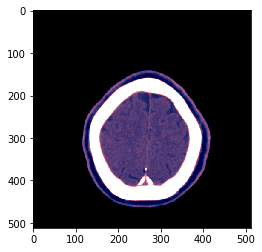

In [ ]:

dcm = pydicom.dcmread(dicom[0])
img = bsb_window(dcm)
print(img.shape)
show_image(img)

##Train

In [ ]:
!ls {OUTPUT_DIR}/{train_dir} | wc

      0       0       0


# Load converted images

Let's test that everything is ok!

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


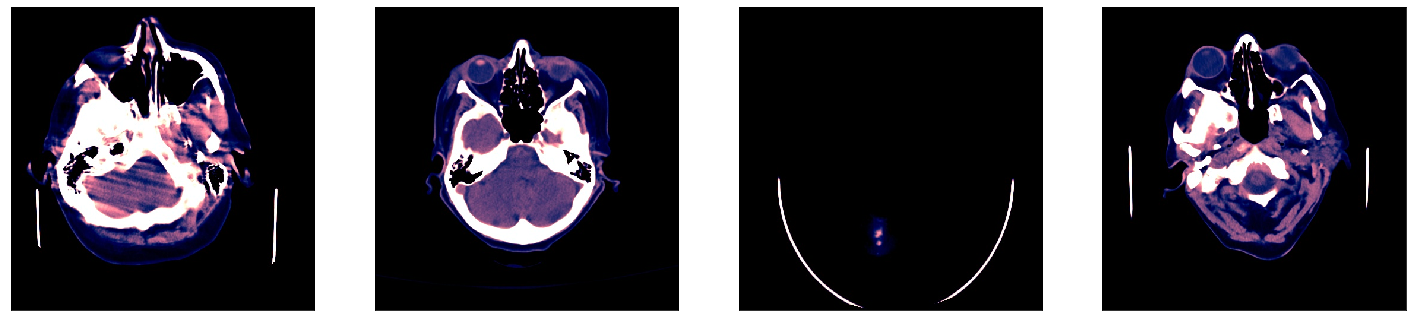

In [ ]:
test_output_path = glob.glob(f"{OUTPUT_DIR}/{test_dir}/*")
img = []
for ii in range(0,4):
  img_path = test_output_path[ii]
# PIL.Image.open(img_path)
  img.append(cv2.imread(img_path))
  print(img[ii].shape)
show_Nimages(img)

# Create Kaggle dataset

In [ ]:
cmd = """
cat <<EOF > output/dataset-metadata.json
{
  "title": "RSNA Test jpg (512x512) Stage2",
  "id": "ratthachat/rsnajpg512stage2",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}
EOF
"""
!eval {cmd}

In [ ]:
!cat output/dataset-metadata.json

{
  "title": "RSNA Test jpg (512x512) Stage2",
  "id": "ratthachat/rsnajpg512stage2",
  "licenses": [
    {
      "name": "CC0-1.0"
    }
  ]
}


In [ ]:
!kaggle datasets create -u --dir-mode zip -p {OUTPUT_DIR}

Starting upload for file stage_2_train_images.zip
100% 22.0/22.0 [00:01<00:00, 15.2B/s]
Upload successful: stage_2_train_images.zip (22B)
Starting upload for file stage_2_test_images.zip
100% 4.94G/4.94G [01:26<00:00, 61.2MB/s]
Upload successful: stage_2_test_images.zip (5GB)
Starting upload for file stage_2_train.csv
100% 114M/114M [00:03<00:00, 39.2MB/s]
Upload successful: stage_2_train.csv (114MB)
Starting upload for file stage_2_sample_submission.csv
100% 19.8M/19.8M [00:01<00:00, 11.2MB/s]
Upload successful: stage_2_sample_submission.csv (20MB)
Your public Dataset is being created. Please check progress at https://www.kaggle.com/ratthachat/rsnajpg512stage2


### Bonus : copy to gdrive!

In [ ]:
!cp -r {YourFiles} /content/drive/My\ Drive/

5
